## Raw data acquisition, linearization, and plotting


Sections in this notebook:

&emsp;Background <br>
1. Import the necessary modules and station information<br>
    1.1 Pick a station <br>
    1.2 Load relevant station information and select timeframe <br>
    1.3 Extract and load raw strain data
2. Linearize, save, and plot

The goal of this notebook is to identify a station and produce level 1 linearized gauge strain data, to be used in the next notebook. 

Tips: 
- If you don't see the cell widget, try running all "initialization" cells or the individual cell, and it should pop up. 
- If at any point you wish to examine the dataframe we continually add to, type ```df.head()``` into a new code cell and run the cell. 
- If something seems off, make sure you ran prior cells. Some cells have dependencies on the cells before it, even between sections. 

***
### Background
***

Raw data is available for download from the IRIS DMC. The data channels are identified with a SEED code that builds into a url for easy access. A url builder can be found [here](http://service.iris.edu/irisws/timeseries/docs/1/builder/), or, as we will see in the code cells below, we can skip manually navigating to the site and build our own SEED code to extract the data, transfer it to our directory, and take a first look. 

We will heavily rely on ObsPy (a python toolbox for seismology) to communicate between the IRIS DMC and our notebook. If you want to explore this tool more, documentation and helpful tutorials can be found [here](https://docs.obspy.org/tutorial/).

Helpful Documents:
- [PBO SEED Codes and Conventions](https://www.unavco.org/projects/project-support/borehole-services/lib/docs/pbo_seed_conventions.pdf)
- [PBO Strainmeter Products Summary](https://www.unavco.org/data/strain-seismic/bsm-data/lib/docs/BOREHOLE_StrainSheet_DP_11.pdf) 
    - this one includes a breakdown of the SEED code (e.g. PB.B007.BS1.T0) naming convention, as pictured below:

<div>
    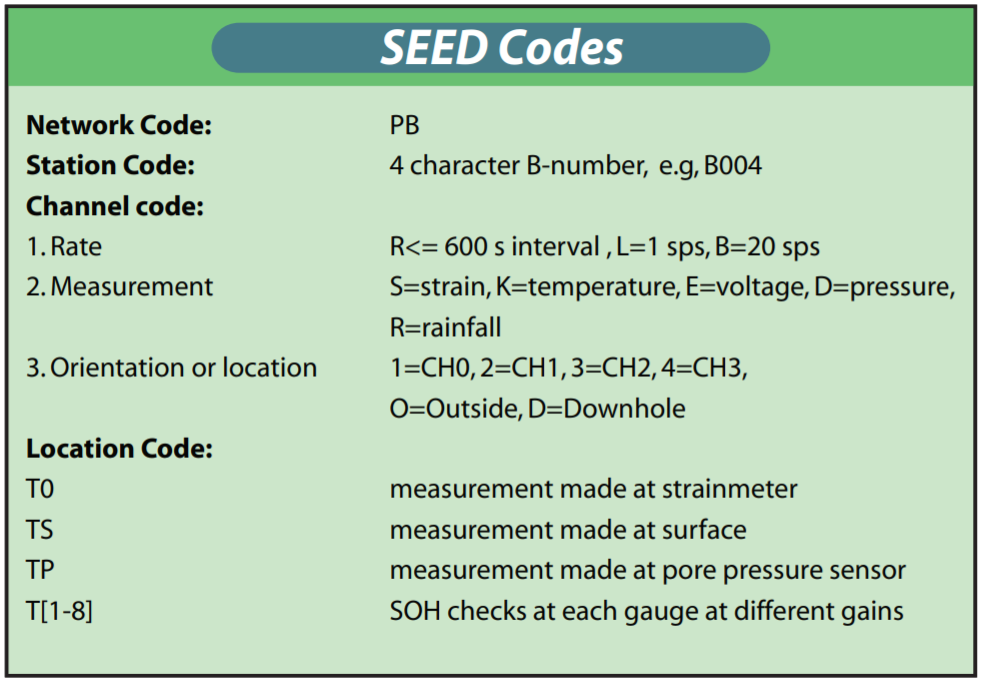
</div>

***
### 1. Import the necessary modules and station information 
***
The first code cell runs automatically on startup, and should not need to be run again. 

In [1]:
# Import modules
# This imports matplotlib for later plotting
import matplotlib.pyplot as plt
# Make plotting interactive
%matplotlib widget
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8, 6

# This imports numpy and pandas for data handling
import numpy as np
import pandas as pd
from datetime import timedelta
import os

# This imports obspy, a python toolbox for seismology,
# the iris web services client, a reader for stream data
# and the UTC date time format
import obspy
from obspy import read, UTCDateTime, read_inventory
from obspy.clients.iris import Client
client = Client()
from obspy.clients.fdsn import Client
inv_client = Client('IRIS')

# These lines import interactive widgets and set style info for later
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
style = {'description_width': 'initial'}
layout=Layout(width='30%', height='40px')

***
### 1.1 Pick a station
***
Enter latitudinal and longitudinal bounds to find available stations at that location. Once you pick a station from the dropdown menu, the network and station seed codes automatically update. You can then pick a sample rate, which updates the partial channel seed code. The location code for the strain gauges is always 'T0'. These parameters are what we will use to extract and transfer the data from IRIS to our notebook environment. 

In [2]:
##### Pick lats and lons to bound a station search
min_lat = widgets.IntText(value=36, description='Min Latitude:',style=style)
max_lat = widgets.IntText(value=37, description='Max Latitude:',style=style)
min_lon = widgets.IntText(value=-118, description='Min Longitude:',style=style)
max_lon = widgets.IntText(value=-117, description='Max Longitude:',style=style)

region = VBox([HBox([min_lat,max_lat]),HBox([min_lon,max_lon])])

update_button = widgets.Button(description="Update Stations", button_style='danger')
uoutput = widgets.Output()

def on_button_click(b):
    with uoutput:
        uoutput.clear_output()
        print('Finding stations...')
        
        inv = inv_client.get_stations(minlatitude=min_lat.value,maxlatitude=max_lat.value,
                                      minlongitude=min_lon.value,maxlongitude=max_lon.value,loc='T0',level='station')
        
        print('...stations found! Click to update the dropdown selection')
        
        global scode, network
        station_list = inv.get_contents()['stations']
        # Build a list of site codes
        station_slice = []
        network_slice = []
        for i in range(0,len(station_list)):
            station_slice.append(station_list[i][3:7])
            network_slice.append(station_list[i][0:2])
        # Build a dictionary of station keys and site code values
        scode_dict = {}
        for i in range(0,len(station_list)):
            scode_dict[station_list[i]] = station_slice[i]
        network_dict = {}
        for i in range(0,len(station_list)):
            network_dict[station_slice[i]] = network_slice[i]   
        network_df = pd.DataFrame(network_dict.values(),network_dict.keys())
        
        site = widgets.Dropdown(
            options=scode_dict,
            description='Pick a station from the list:',
        ) 
        display(site)
        # initial values
        scode = site.value
        network = network_df.loc[site.value][0]
        # Change the station and network as the dropdown is changed
        def the_codes(siteval):
            global scode, network
            scode = siteval
            network = network_df.loc[siteval][0]
        def on_select(change):
            the_codes(change.new)
        site.observe(on_select,names='value')

update_button.on_click(on_button_click)

# Partial channel code (contains sample rate and instrument type, gauge orientation 
# is looped in the next cell)

cha_dict = {'1 sps':'LS','20 sps':'BS','1/600 sps':'RS'}
chan = widgets.Dropdown(
    options=cha_dict,
    description='Sample Rate:',
    )
# initial channel value
cha = cha_dict['1 sps']
def cha_codes(siteval):
    global cha
    cha = siteval
output_cha = widgets.Output()
def cha_select(change):
    cha_codes(change.new)
    with output_cha:
        output_cha.clear_output()
        if change['type'] == 'change' and change['name'] == 'value':
            print('The partial channel code for this sample rate is',change['new'],'*')

chan.observe(cha_select,names='value')

print('The location code for the strain guages is always T0')
loc='T0'

display(VBox([region,update_button, uoutput,chan,output_cha]))

The location code for the strain guages is always T0


***
### 1.2 Load relevant station information and select timeframe
***

This section uses information chosen in the previous cell to extract the station metadata information from UNAVCO's station list, found here: https://www.unavco.org/data/strain-seismic/bsm-data/lib/docs/bsm_metadata.txt.

You can pick start and end times for the data you wish to analyze. The calendar start date is automatically set to 10 months after the BSM install date (after the grout has had sufficient time to cure for most stations), and the end date is automatically set to ~ 1 month after that start date. Due to time limitations from the IRIS DMC, only one month of data can be downloaded at a time. Be prepared to wait if you select the higher rate data and a long timeframe - 1 month of 1 sps data is over 2.5 million data points for just one gauge... we have 4 gauges per station to work with. 

In [3]:
# Show the metadata for the site

mbutton = widgets.Button(description="Load Station Information", layout=layout, button_style='danger')
moutput = widgets.Output()

def on_mbutton_clicked(b):
    with moutput:
        moutput.clear_output()
        print('Working on it...')
        global metadata, start, end
        metalink = 'https://www.unavco.org/data/strain-seismic/bsm-data/lib/docs/bsm_metadata.txt'
        print('BSM metadata from: ',metalink)
        metadata = pd.read_csv(metalink,sep='\s+',index_col=False, header=0,
                   names=['BNUM','NAME','LAT','LONG','ELEV(m)','INSTALL_DATE','CH0(EofN)','BSM_Depth(m)','SEISMOMETER_Depth(m)','PORE_DEPTH(m)','DATA_START',' ','DATA_END','GAP(m)','L_DATE','L0(cnts)','L1(cnts)','L2(cnts)','L3(cnts)','REGION'])

        metadata.index = metadata['BNUM']
        metadata = metadata.loc[scode,:]
        print(metadata)
        
        start_date = widgets.DatePicker(
            description='Start Date',
            # Make the start time sufficiently after the install date to account for grout curing
            value = UTCDateTime(metadata['INSTALL_DATE'])+timedelta(330),
            disabled=False
        )
            
        end_date = widgets.DatePicker(
            description='End Date',
            value = UTCDateTime(start_date.value) + timedelta(30),
            disabled=False
        )
        # Initial start and end dates
        start = UTCDateTime(start_date.value)
        print(start)
        end = UTCDateTime(end_date.value)
        def the_tcodes(siteval):
            global start, end
            start = UTCDateTime(start_date.value)
            end = UTCDateTime(end_date.value)
        def on_tselect(change):
            the_tcodes(change.new)
        start_date.observe(on_tselect,names='value')
        end_date.observe(on_tselect,names='value')
        
        print(' ')
        print('Pick a date range for the data you want to download:')
        display(HBox([start_date,end_date]))
        
mbutton.on_click(on_mbutton_clicked)

display(mbutton, moutput)


Button(button_style='danger', description='Load Station Information', layout=Layout(height='40px', width='30%'…

Output()

***
### 1.3 Extract and load raw strain data
***

In this section, we use the ObsPy timeseries client to extract the data from IRIS to a local pandas dataframe. Once it is in a dataframe, we will replace the periodic flagged data (which appears as 999999 in the raw data) with ```None```.

In [4]:
# Extract and save the gauge data

sbutton = widgets.Button(description="Extract and Transfer Data to a Dataframe", layout=Layout(width='50%', height='40px'),
                          button_style='danger')
soutput = widgets.Output()

def on_sbutton_clicke(b):
    with soutput:
        soutput.clear_output()
        print('Working on it...')
        print('this cell can take some time depending on the amount of data specified...')
        global odf, ch
        # create "dictionaries" for the gauge channels
        # ch will store the data stream for each gauge
        # (IRIS data is in multiple "stream" objects that need to be combined)
        # ts will store the time and data for each gauge
        ch = {'0':[],'1':[],'2':[],'3':[]}
        
        # This first for loop brings in the data from iris using
        # the ObsPy client
        init = []
        for channel in ch: 
            # assign the gauge channel number
            n = str(int(channel)+1)
            # Use obspy client to get the timeseries from iris
            ch[channel] = client.timeseries(network,scode,loc,cha+n,start,end)
            
        # Establish a dataframe with the raw data to be linearized
        # Replace bad data values flagged with 999999 to None 
        tmpd = {'0':None,'1':None,'2':None,'3':None}
        
        for channel in ch:
            empty = np.array([])
            for i in range(0,len(ch[channel])):
                b = np.append(empty,ch[channel][i].data)
            tmpd[channel] = b
        
        for i in range(0,len(ch['0'])):
            empty = np.array([])
            tmpt = np.append(empty,ch['0'][i].times('timestamp'))
            
        odf = pd.DataFrame({'ch0':tmpd['0'],'ch1':tmpd['1'],'ch2':tmpd['2'],'ch3':tmpd['3']},tmpt).replace(999999,None)
        print('Done!')
sbutton.on_click(on_sbutton_clicke)

display(sbutton, soutput)

Button(button_style='danger', description='Extract and Transfer Data to a Dataframe', layout=Layout(height='40…

Output()

In [9]:
# Run this cell if you want to see the IRIS seed metadata
# and a static plot of channel 0 raw strain
print(ch['0'][0].stats)
plt.close()
#ch['0'].plot()

         network: PB
         station: B073
        location: T0
         channel: BS1
       starttime: 2012-01-21T00:00:00.000000Z
         endtime: 2012-01-22T00:00:00.000000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 1728001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 2881, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 1475072})


***
## 2. Linearize, save, and plot
***
    
The strainmeter data from each guage will be linearized by the following equation: 
> $$ u_t =  \left[\frac{d_t/1e8}{1-d_t/1e8}-\frac{d_o/1e8}{1-d_o/1e8}\right]\frac{R}{M}$$
- $u_t$: Linear gauge strain
- $d_t$: raw data value at time $t$
- $d_o$: raw data value at time $0$
- $M$: gauge diameter, always 0.087 m
- $R$: gauge reference gap, $1$ or $2$ $*10^{-4}$ m

The code cell below performs this calculation, calling the reference gap from the metadata loaded in section 1.2 and setting the initial time to the data start time. All results are stored as microstrain (ms).

Options to save the data for use in the next notebook and to plot the linearized gauge strain appear after the data is linearized. 


In [5]:
# Linearize
lbutton = widgets.Button(description="Linearize the data", button_style='danger')
loutput = widgets.Output()

def on_lbutton_click(b):
    with loutput:
        loutput.clear_output()
        print('Working on it...')
        global df
        ut = {'0':None,'1':None,'2':None,'3':None}
        comment = {'0':None,'1':None,'2':None,'3':None}
        R = metadata['GAP(m)']
        M = 0.087 # in meters
        time = []
        for t in range(0,len(odf)):
            time.append(UTCDateTime(odf.index[t]))
        for i in ut:
            empty = []
            d0 = odf.iat[0,int(i)]/1e8
            astr = f'# The subtracted reference term is {d0*R/M*1e6} [ms] for gauge {i}'
            comment[i] = astr
            print(astr)
            for j in range(0,len(odf)):
                dt = odf.iat[j,int(i)]/1e8
                empty.append(((dt/(1-dt))-(d0/(1-d0)))*R/M*1e6)
                ut[i] = empty
        df = pd.DataFrame({metadata['NAME']:time,'ch0 [ms]':ut['0'],'ch1 [ms]':ut['1'],'ch2 [ms]':ut['2'],'ch3 [ms]':ut['3']})
        print('Use these values if you wish to combine time series later on.')
        # Save the data to a file for the next notebook
        chkf = widgets.Checkbox(value=False,
                description='Save level 1 data file for next notebook?',
                disabled=False, style=style
                )
        foutput = widgets.Output()
        display(chkf,foutput)
        def on_checkf(c):
            with foutput:
                foutput.clear_output()
                dir = './DataFiles/Level1/'
                file = network + '.' + scode + '.' + loc + '.' + cha + '.' +str(start.date)+'_Level1.txt'
                os.makedirs(dir, exist_ok=True)
                # Write the reference strain value as comment
                with open(dir+file,'w') as f:
                    for val in ['0','1','2','3']:
                        f.write(comment[val]+'\n')
                    f.close()
                df.to_csv(dir+file,sep='\t',index=False,mode='a')
                print('Saved!')
        chkf.observe(on_checkf,'value')
        
        # Plotting
        chk = widgets.Checkbox(value=False,
                description='Plot?',
                disabled=False, style=style
                )
        coutput = widgets.Output()
        display(chk,coutput)
        def on_check(c):
            with coutput:
                coutput.clear_output()
                plt.close()
                time_factor = 1/60/60/24
                plt.plot((odf.index - odf.index[0])*time_factor,df['ch0 [ms]'],label='ch0')
                plt.plot((odf.index - odf.index[0])*time_factor,df['ch1 [ms]'],label='ch1')
                plt.plot((odf.index - odf.index[0])*time_factor,df['ch2 [ms]'],label='ch2')
                plt.plot((odf.index - odf.index[0])*time_factor,df['ch3 [ms]'],label='ch3')
                plt.gcf().autofmt_xdate()
                plt.title(scode+' Linearized Strain')
                plt.ylabel('Microstrain')
                plt.xlabel('Days after '+str(UTCDateTime(odf.index[0]))[0:10])
                plt.legend()
        chk.observe(on_check,'value')

lbutton.on_click(on_lbutton_click)

display(lbutton, loutput)

Button(button_style='danger', description='Linearize the data', style=ButtonStyle())

Output()